# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
df_train_raw = pd.read_parquet('data/train.parquet')

EDA has been done beforehand, not shown here

# Step 1: Aggregation per user and per day

In [3]:
warnings.filterwarnings('ignore')

def step_1_daily_aggregation(df):
    """
    Transforms raw logs into a Daily User Activity df (grouped by userid and day)

    Logic:
    1. Converts timestamps to daily dates
    2. Filter out the target event
    3. Feature engineers some specific page events (NextSong, Errors, etc.) into features
    4. Aggregates daily metrics like listening time or session count
    5. Encodes the 'level' column (paid/free) to binary (paid=1, free=0)
    """

    # 1.
    df['date'] = pd.to_datetime(df['ts'], unit='ms').dt.floor('D')

    # 2.
    df_features = df[df['page'] != 'Cancellation Confirmation']

    # 3.
    relevant_pages = [
        'NextSong', 'Thumbs Up', 'Thumbs Down',
        'Error', 'Add Friend', 'Roll Advert', 'Upgrade', 'Downgrade',
        'Add to Playlist', 'Settings', 'Help'
    ]
    df_relevant = df_features[df_features['page'].isin(relevant_pages)]

    daily_page_counts = df_relevant.pivot_table(
        index=['userId', 'date'],
        columns='page',
        values='ts',
        aggfunc='count',
        fill_value=0
    )
    daily_page_counts.columns = [f'daily_{col.replace(" ", "")}' for col in daily_page_counts.columns]

    # 4.
    daily_stats = df_features.groupby(['userId', 'date']).agg({
        'length': 'sum',              # Listening time
        'sessionId': 'nunique',       # Session count
        'level': 'last',              # Paid/Free
        'registration': 'max',        # Registration time
        'artist': 'nunique',          # Diversity
    }).rename(columns={
        'length': 'daily_listen_time',
        'sessionId': 'daily_sessions',
        'level': 'status_level',
        'artist': 'daily_unique_artists'})

    # merging both df
    df_daily = pd.concat([daily_page_counts, daily_stats], axis=1).reset_index()

    # 5.
    df_daily['is_paid'] = df_daily['status_level'].apply(lambda x: 1 if x == 'paid' else 0)
    df_daily.drop('status_level', axis=1, inplace=True)

    return df_daily

In [4]:
df_daily_train = step_1_daily_aggregation(df_train_raw)
print("Step 1 done")

Step 1 done


In [5]:
df_daily_train.head()

,userId,date,daily_AddFriend,daily_AddtoPlaylist,daily_Downgrade,daily_Error,daily_Help,daily_NextSong,daily_RollAdvert,daily_Settings,daily_ThumbsDown,daily_ThumbsUp,daily_Upgrade,daily_listen_time,daily_sessions,registration,daily_unique_artists,is_paid
0,1000025,2018-10-02,3.0,2.0,1.0,0.0,1.0,95.0,2.0,0.0,2.0,5.0,1.0,24922.31447,2,2018-07-10 09:30:08,91,1
1,1000025,2018-10-03,6.0,13.0,2.0,0.0,2.0,317.0,1.0,1.0,3.0,21.0,0.0,77571.72247,1,2018-07-10 09:30:08,282,1
2,1000025,2018-10-04,0.0,5.0,3.0,0.0,1.0,201.0,0.0,0.0,3.0,12.0,0.0,49228.60436,1,2018-07-10 09:30:08,191,1
3,1000025,2018-10-05,0.0,1.0,2.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,5720.83247,1,2018-07-10 09:30:08,22,1
4,1000025,2018-10-06,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,888.24027,1,2018-07-10 09:30:08,3,1


# Step 2: Feature Engineering

In [6]:
def step_2_feature_engineering(df_daily):
    """
    Generates Time-Series Features and other signals. Since dataset is only made of
    less than 2 months worth of logs, the rolling windows are very short

    Logic:
    1. Sorts our df_daily data by User and Date
    2. Computes Rolling Windows (7d, 30d) for short-term trends
    3. Calculates Lifetime Snapshots (Expanding Mean/Std) for long-term context
    4. Computes complex signals: recency (days since active), diversity, and ratios
    5. Cleans up some useless features
    """

    # 1.
    df_daily = df_daily.sort_values(['userId', 'date'])

    # 2.
    features_to_roll = [
        'daily_NextSong', 'daily_Error', 'daily_ThumbsDown', 'daily_ThumbsUp',
        'daily_RollAdvert', 'daily_listen_time', 'daily_AddFriend', 'daily_Help',
        'daily_AddtoPlaylist', 'daily_Downgrade', 'daily_Upgrade', 'daily_sessions',
        'daily_unique_artists'
    ]

    # 3.
    for col in features_to_roll:
        grouped = df_daily.groupby('userId')[col]

        # we always shift the data for 1 day to make sure we correctly avoid
        # data leakage from the future

        # short-term trends (rolling)
        df_daily[f'{col}_last_7d'] = grouped.transform(lambda x: x.shift(1).rolling(7, min_periods=1).sum())
        df_daily[f'{col}_last_30d'] = grouped.transform(lambda x: x.shift(1).rolling(30, min_periods=1).sum())

        # lifetime stats
        df_daily[f'{col}_lifetime_avg'] = grouped.transform(lambda x: x.shift(1).expanding().mean())
        df_daily[f'{col}_lifetime_std'] = grouped.transform(lambda x: x.shift(1).expanding().std().fillna(0))

        # scaling 30d trend to compare fairly to 7d
        avg_30d_scaled = (df_daily[f'{col}_last_30d'] / 30) * 7
        df_daily[f'{col}_trend'] = df_daily[f'{col}_last_7d'] / (avg_30d_scaled + 1e-5)
        # eps added to avoid dividing by 0

    # 4. signals feature engineering
    # diversity = unique artists(Lifetime)
    df_daily['lifetime_unique_artists'] = df_daily.groupby('userId')['daily_unique_artists'].transform(
            lambda x: x.shift(1).expanding().sum())

    # recency (days since last active)
    df_daily['prev_date'] = df_daily.groupby('userId')['date'].shift(1)
    df_daily['days_since_last_active'] = (df_daily['date'] - df_daily['prev_date']).dt.days
    df_daily['days_since_last_active'] = df_daily['days_since_last_active'].fillna(0)
    df_daily.drop('prev_date', axis=1, inplace=True)

    # number of days since registration
    reg_date = pd.to_datetime(df_daily['registration']).dt.floor('D')
    df_daily['days_since_reg'] = (df_daily['date'] - reg_date).dt.days

    # Ratios
    # Ad annoyance ratio
    df_daily['ratio_ads_per_song'] = df_daily['daily_RollAdvert_last_30d'] / (df_daily['daily_NextSong_last_30d'] + 1)

    # session quality: How many songs/minutes per session on average?
    df_daily['avg_songs_per_session'] = df_daily['daily_NextSong_last_30d'] / (df_daily['daily_sessions_last_30d'] + 1)
    df_daily['avg_time_per_session'] = df_daily['daily_listen_time_last_30d'] / (df_daily['daily_sessions_last_30d'] + 1)

    # Completion Rate: (Songs Played) / (Songs + Errors + ThumbsDown)
    # A low rate indicates dissatisfaction/skipping/errors
    negative_events = df_daily['daily_ThumbsDown_last_30d'] + df_daily['daily_Error_last_30d']
    df_daily['completion_rate'] = df_daily['daily_NextSong_last_30d'] / (df_daily['daily_NextSong_last_30d'] + negative_events + 1)

    # downgrade propensity
    total_thumbs = df_daily['daily_ThumbsDown_last_30d'] + df_daily['daily_ThumbsUp_last_30d']
    df_daily['downgrade_propensity'] = df_daily['daily_ThumbsDown_last_30d'] / (total_thumbs + 1)

    # 5. cleanup
    cols_to_drop = ['raw_agent', 'userAgent', 'summary', 'artist']
    for c in cols_to_drop:
        if c in df_daily.columns:
            df_daily.drop(c, axis=1, inplace=True)

    return df_daily.fillna(0)

In [7]:
df_features_train = step_2_feature_engineering(df_daily_train)
print("Step 2 done")

Step 2 done


# Step 3: Regroup dataset for a static target (1 row per user)

In [8]:
def step_3_define_static_target(df_features, df_raw_logs):
    """
    Constructs the training dataset and binary target for churn prediction, applying
    Random Negative Sampling to prevent survivorship bias.

    Logic:
    1. Identifies churners based on the 'Cancellation Confirmation' event.
    2. Strategies for Feature Snapshots (Point-in-Time Correctness):
    - Churners (Class 1): Uses the last active day (moment of churn) as the snapshot.
    - Non-Churners (Class 0): Selects a RANDOM active day from their history as the snapshot.
    (This prevents the model from learning that "long history" automatically implies "safe").
    3. Assigns binary labels: 1 for churners, 0 for non-churners.
    """

    # 1.
    # Split into two groups
    churn_users = df_raw_logs[df_raw_logs['page'] == 'Cancellation Confirmation']['userId'].unique()
    df_churners = df_features[df_features['userId'].isin(churn_users)]
    df_non_churners = df_features[~df_features['userId'].isin(churn_users)]

    # 2. 3.
    # Churners: Take the last day (The moment before churn)
    # this captures the trends leading up to their final moment
    final_churn = df_churners.sort_values('date').groupby('userId').tail(1)
    final_churn['target_churn'] = 1

    # Non-Churners: Pick a RANDOM day from their history
    # This prevents the model from relying on "Max Days" as a proxy for safety
    final_non_churn = df_non_churners.groupby('userId').sample(n=1, random_state=5)
    final_non_churn['target_churn'] = 0

    print(f"class balance: {final_churn['target_churn'].value_counts().to_dict()}")
    print(f"class balance: {final_non_churn['target_churn'].value_counts().to_dict()}")

    return pd.concat([final_churn, final_non_churn])

In [9]:
def step_3_define_static_target(df_features, df_raw_logs, cutoff_date='2018-10-15'):
    """
    Creates a snapshot-based training set that mimics the test scenario.

    Logic:
    1. Uses data ONLY before 'cutoff_date' for features.
    2. Uses data AFTER 'cutoff_date' (10-day window) for the target.
    3. Target = 1 if user churns within [cutoff_date, cutoff_date + 10 days].
    """

    cutoff_ts = pd.Timestamp(cutoff_date)
    # The competition window is 10 days after the observation
    prediction_window_end = cutoff_ts + pd.Timedelta(days=10)

    # 1. Filter Features: Keep only activity BEFORE the cutoff
    # This prevents leaking future information into the features
    df_history = df_features[df_features['date'] <= cutoff_ts].copy()

    # 2. Take the last known state for each user as of the cutoff date
    # This is exactly what we will do for the test set (as of 2018-11-20)
    df_snapshot = df_history.sort_values('date').groupby('userId').tail(1)

    # 3. Define Target: Look AHEAD into the future (after cutoff)
    # Identify users who cancelled in the specific window
    churn_events = df_raw_logs[df_raw_logs['page'] == 'Cancellation Confirmation']
    churn_events['churn_date'] = pd.to_datetime(churn_events['ts'], unit='ms').dt.floor('D')

    # User churns if their cancellation is within the window
    churners_in_window = churn_events[
        (churn_events['churn_date'] > cutoff_ts) &
        (churn_events['churn_date'] <= prediction_window_end)
    ]['userId'].unique()

    # 4. Assign Labels
    df_snapshot['target_churn'] = df_snapshot['userId'].isin(churners_in_window).astype(int)

    print(f"Snapshot Date: {cutoff_date}")
    print(f"Prediction Window: {cutoff_date} to {prediction_window_end.date()}")
    print(f"Class Balance: {df_snapshot['target_churn'].value_counts().to_dict()}")

    return df_snapshot

In [10]:
# Create training set using a cutoff (e.g., Nov 1st)
# This leaves ~3 weeks of history for features, and checks churn in early Nov.
df_final_train = step_3_define_static_target(df_features_train, df_train_raw, cutoff_date='2018-10-15')

Snapshot Date: 2018-10-15
Prediction Window: 2018-10-15 to 2018-10-25
Class Balance: {0: 15700, 1: 837}


In [11]:
# df_final_train = step_3_define_static_target(df_features_train, df_train_raw)
# print(df_final_train.shape)
# print("Step 3 done")

In [12]:
df_final_train.head()

,userId,date,daily_AddFriend,daily_AddtoPlaylist,daily_Downgrade,daily_Error,daily_Help,daily_NextSong,daily_RollAdvert,daily_Settings,...,daily_unique_artists_trend,lifetime_unique_artists,days_since_last_active,days_since_reg,ratio_ads_per_song,avg_songs_per_session,avg_time_per_session,completion_rate,downgrade_propensity,target_churn
53928,1255876,2018-10-01,2.0,5.0,2.0,0.0,0.0,187.0,0.0,2.0,...,0.0,0.0,0.0,32,0.0,0.0,0.0,0.0,0.0,0
53902,1255649,2018-10-01,2.0,0.0,0.0,0.0,0.0,31.0,2.0,0.0,...,0.0,0.0,0.0,129,0.0,0.0,0.0,0.0,0.0,0
199050,1984991,2018-10-01,1.0,2.0,1.0,0.0,0.0,69.0,6.0,2.0,...,0.0,0.0,0.0,193,0.0,0.0,0.0,0.0,0.0,0
196262,1969354,2018-10-01,0.0,1.0,0.0,0.0,0.0,20.0,5.0,0.0,...,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0
103507,1505495,2018-10-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,19,0.0,0.0,0.0,0.0,0.0,0


# Step 4: First model training

In [13]:
def train_model(df_final):
    """
    Trains the XGBoost Classifier.

    Logic:
    1. Drops metadata columns (userId, date) to isolate features
    2. Performs a Stratified Random Split (80/20) because rows are independent users
    3. Calculates a dynamic hyperparam `scale_pos_weight` to handle class imbalance
    4. Trains the model and outputs Validation Report, AUC, and Feature Importance
    """

    # 1.
    cols_to_drop = ['userId', 'date', 'registration', 'target_churn']

    X = df_final.drop(columns=cols_to_drop)
    y = df_final['target_churn']

    # 2.
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y)

    # 3.
    pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
    print(f"Calculated scale_pos_weight: {pos_weight:.2f}")

    # let's use common standard hyperparams first before our future tuning
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        scale_pos_weight=pos_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=5
    )

    # 4.
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    print("\n- Validation Results -")
    print(classification_report(y_val, y_pred))
    print(f"AUC-ROC score: {roc_auc_score(y_val, y_proba):.4f}")

    importance_dict = model.get_booster().get_score(importance_type='weight')
    importance_df = (
    pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
      .sort_values('importance', ascending=False)
    )

    xgb.plot_importance(model, max_num_features=25, importance_type='weight')
    plt.title("Features Importance (Top)")
    plt.show();

    return model, importance_dict

Calculated scale_pos_weight: 18.74

- Validation Results -
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      3141
           1       0.11      0.50      0.18       167

    accuracy                           0.77      3308
   macro avg       0.54      0.65      0.53      3308
weighted avg       0.92      0.77      0.83      3308

AUC-ROC score: 0.7161


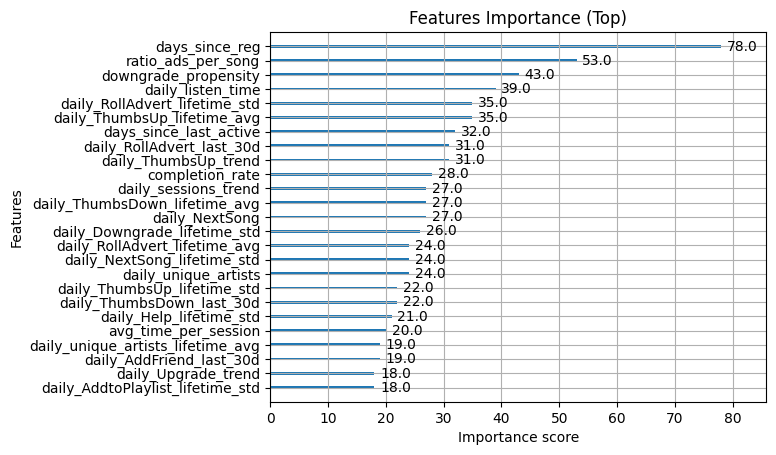

In [14]:
trained_model = train_model(df_final_train)[0]

# Step 5: Training optimized model with RandomizedSearch & Feature Selection

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

def train_optimized_model(df_final):
    """
    Now trains and optimizes the XGBoost Classifier with automated
    Feature Selection and Hyperparameter Tuning.

    Logic:
    1. Splits Data: Performs Stratified Random Split (80/20).
    2. Feature Selection: Fits a base XGBoost model and uses `SelectFromModel` to
       aggressively prune weak features (threshold = 0.5 * mean importance).
    3. Hyperparameter Tuning: Runs `RandomizedSearchCV` on the surviving features
       to optimize Depth, Learning Rate, Imbalance Weight, and Regularization (L1/L2).
    4. Evaluation: Outputs optimal params, Classification Report, AUC, and an
       Importance DataFrame for the final model.
    5. Generate our optimized features importance dataframe
    """

    # 1.
    cols_to_drop = ['userId', 'date', 'registration', 'target_churn']

    X = df_final.drop(columns=cols_to_drop)
    y = df_final['target_churn']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y)

    # 2. automated feature selection
    print("--> running feature selection (dropping noise)")
    selector_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        scale_pos_weight=3.5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=5
    )

    selector_model.fit(X_train, y_train)

    # Select features > 0.5 * Mean Importance (Aggressive pruning of noise)
    selection = SelectFromModel(selector_model, threshold='0.5*mean', prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_val = selection.transform(X_val)

    # Recover names of kept features for reporting
    feature_idx = selection.get_support()
    feature_names = X_train.columns[feature_idx].tolist()
    print(f"dropped {X_train.shape[1] - len(feature_names)} features.")
    print(f"kept {len(feature_names)} features.")

    # 3. hyperparams tuning
    print("\n--> running random search (with regularization)")

    param_grid = {
        'max_depth': [3, 4, 5],   # keep shallow trees to prevent overfitting
        'n_estimators': [100, 200],
        'subsample': [0.7, 0.8, 0.9],        # Row sampling
        'colsample_bytree': [0.6, 0.8],      # Feature sampling
        'scale_pos_weight': [8, 10, 12],
        'reg_alpha': [0, 0.1, 1.0, 5.0],     # L1 Regularization (Lasso-like)
        'reg_lambda': [1.0, 5.0, 10.0],      # L2 Regularization (Ridge-like)
        'gamma': [0, 1, 3]                   # Min loss reduction to split
    }

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        random_state=5)

    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=50,
        scoring='roc_auc',   # Optimize for AUC
        cv=5,
        verbose=1,
        random_state=5,
        n_jobs=-1
    )

    random_search.fit(select_X_train, y_train)

    # 4. Evaluation
    best_model = random_search.best_estimator_
    print(f"\n --> best params: {random_search.best_params_}")

    y_pred = best_model.predict(select_X_val)
    y_prob = best_model.predict_proba(select_X_val)[:, 1]

    print("\n- Final Optimized Results -")
    print(classification_report(y_val, y_pred))
    print(f"AUC-ROC Score: {roc_auc_score(y_val, y_prob):.4f}")

    xgb.plot_importance(best_model, max_num_features=10, importance_type='weight')
    plt.title("Top Features (Optimized)")
    plt.show();

    # 5. Generate importance feature dataframe
    importance_dict = best_model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df = importance_df.sort_values('importance', ascending=False)

    return best_model, feature_names, importance_df

--> running feature selection (dropping noise)
dropped 5 features.
kept 83 features.

--> running random search (with regularization)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 --> best params: {'subsample': 0.9, 'scale_pos_weight': 8, 'reg_lambda': 10.0, 'reg_alpha': 1.0, 'n_estimators': 100, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 0.6}

- Final Optimized Results -
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3141
           1       0.14      0.19      0.16       167

    accuracy                           0.90      3308
   macro avg       0.55      0.56      0.56      3308
weighted avg       0.92      0.90      0.91      3308

AUC-ROC Score: 0.6713


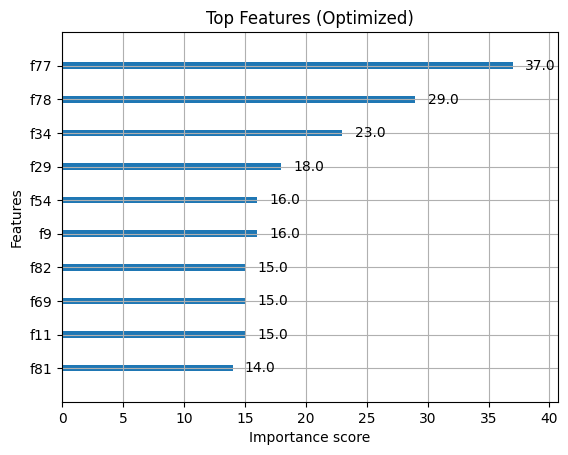

In [16]:
optimized_model_randomized, final_features, final_importance_df = train_optimized_model(df_final_train)

# Step 6: Fine-tuning model with GridSearch

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

def train_fine_tuned_model(df_final):
    """
    Now performs GridSearch Fine-Tuning.

    Logic:
    1. Splits Data: Performs Stratified Random Split (80/20).
    2. Feature Selection: Fits a base XGBoost model and uses `SelectFromModel` to
       aggressively prune weak features (threshold = 0.5 * mean importance).
    3. Hyperparameter Tuning: Runs `RandomizedSearchCV` on the surviving features
       to optimize Depth, Learning Rate, Imbalance Weight, and Regularization (L1/L2).
    4. Evaluation: Outputs optimal params, Classification Report, AUC, and an
       Importance DataFrame for the final model.
    5. Generate our optimized features importance dataframe
    """

    # 1.
    cols_to_drop = ['userId', 'date', 'registration', 'target_churn']
    X = df_final.drop(columns=cols_to_drop)
    y = df_final['target_churn']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y)

    # 2. automated feature selection
    print("--> running feature selection (dropping noise)")
    selector_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=600,
        learning_rate=0.03,
        max_depth=4,
        scale_pos_weight=10.0,
        tree_method='hist',
        eval_metric='logloss',
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=5)

    selector_model.fit(X_train, y_train)

    # Feature Selection
    selection = SelectFromModel(selector_model, threshold='0.5*mean', prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_val = selection.transform(X_val)

    # Recover names of kept features for reporting
    feature_mask = selection.get_support()
    feature_names = X_train.columns[feature_mask].tolist()
    print(f"dropped {X_train.shape[1] - len(feature_names)} features.")
    print(f"kept {len(feature_names)} features.")

    # 3. hyperparams tuning
    print("\n--> running grid search (with regularization)")

    # we lock in params which turned great during randomized search
    # and tune key params
    param_grid = {
        'max_depth': [4],
        'n_estimators': [550, 600, 650],
        'learning_rate': [0.03],
        'subsample': [0.9],
        'colsample_bytree': [0.7],
        'scale_pos_weight': [9.0, 10.0],
        'reg_alpha': [2.0],
        'reg_lambda': [10.0, 11.0],
        'gamma': [1]
    }

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=5,
        n_jobs=-1
    )

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(select_X_train, y_train)

    # 4. Evaluation
    best_model = grid_search.best_estimator_
    print(f"\n --> best params: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")

    y_pred = best_model.predict(select_X_val)
    y_prob = best_model.predict_proba(select_X_val)[:, 1]

    print("\n- Final Optimized Results -")
    print(classification_report(y_val, y_pred))
    print(f"AUC-ROC Score: {roc_auc_score(y_val, y_prob):.4f}")

    # 5. Importance
    importance_dict = best_model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df = importance_df.sort_values('importance', ascending=False)

    return best_model, feature_names, importance_df

In [18]:
optimized_model, final_features, final_importance_df = train_fine_tuned_model(df_final_train)

--> running feature selection (dropping noise)
dropped 0 features.
kept 88 features.

--> running grid search (with regularization)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 --> best params: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 550, 'reg_alpha': 2.0, 'reg_lambda': 11.0, 'scale_pos_weight': 9.0, 'subsample': 0.9}
Best CV Score: 0.6588

- Final Optimized Results -
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3141
           1       0.13      0.15      0.14       167

    accuracy                           0.91      3308
   macro avg       0.54      0.55      0.54      3308
weighted avg       0.91      0.91      0.91      3308

AUC-ROC Score: 0.6897


# Step 7: 5-Fold Ensemble Prediction + Generate output

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

def train_5fold_ensemble(df_final, params):
    """
    Trains 5 models and returns them along with the optimal threshold
    found via Out-Of-Fold (OOF) predictions.
    """
    # 1. Setup Data
    cols_to_drop = ['userId', 'date', 'registration', 'target_churn']
    X = df_final.drop(columns=cols_to_drop)
    y = df_final['target_churn']
    feature_names = X.columns.tolist()

    # 2. Setup K-Fold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

    models = []
    oof_preds = np.zeros(len(X)) # to store predictions for threshold tuning

    print(f"Starting 5-Fold Training...")

    # 3. training Loop
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train Model
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, verbose=False)

        # predict on validation (OOF)
        val_probs = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_probs

        # store model
        models.append(model)
        print(f"Fold {fold+1} AUC: {roc_auc_score(y_val, val_probs):.4f}")

    # 4. Find Best Threshold using OOF predictions
    # This prevents overfitting the threshold to a single validation set
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.arange(0.3, 0.7, 0.01):
        preds = (oof_preds >= thresh).astype(int)
        score = f1_score(y, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh

    print(f"\nOverall OOF AUC: {roc_auc_score(y, oof_preds):.4f}")
    print(f"Optimal Threshold found: {best_thresh:.2f} (F1: {best_f1:.4f})")

    return models, best_thresh, feature_names

def generate_ensemble_submission(models, best_thresh, test_path, feature_cols):
    # 1. Load & Process Test Data
    print("Loading and processing test data...")
    df_test_raw = pd.read_parquet(test_path)
    df_daily_test = step_1_daily_aggregation(df_test_raw)
    df_features_test = step_2_feature_engineering(df_daily_test)

    # Snapshot last day
    df_test_last = df_features_test.sort_values('date').groupby('userId').tail(1)

    # 2. Align Columns (Add missing cols with 0)
    X_test = df_test_last.copy()
    for col in feature_cols:
        if col not in X_test.columns:
            X_test[col] = 0
    X_test = X_test[feature_cols] # Enforce order

    # 3. Average Predictions from 5 Models
    print("Predicting with 5-model ensemble...")
    avg_probs = np.zeros(len(X_test))
    for model in models:
        avg_probs += model.predict_proba(X_test)[:, 1]

    avg_probs = avg_probs / len(models)

    # 4. Create Submission
    submission = pd.DataFrame({
        'id': df_test_last['userId'],
        'target_prob': avg_probs,
        'target_binary': (avg_probs >= best_thresh).astype(int)
    })

    # Save files
    submission[['id', 'target_binary']].rename(columns={'target_binary': 'target'}).to_csv('submissions/submission_ensemble_binary2.csv', index=False)
    submission[['id', 'target_prob']].rename(columns={'target_prob': 'target'}).to_csv('submissions/submission_ensemble_prob.csv', index=False)

    print(f"Saved ensemble submissions using threshold {best_thresh:.2f}")

    return submission

In [20]:
# 1. Retrieve Best Params from Step 6
# optimized_model is the model returned by the GridSearch
ensemble_params = optimized_model.get_params()

# force specific settings for stability
ensemble_params['random_state'] = 5
ensemble_params['n_jobs'] = -1
ensemble_params['eval_metric'] = 'logloss'

print(f"Training ensemble with params: {ensemble_params}")

# 2. train 5-Fold Ensemble
models, optimal_thresh, feature_names = train_5fold_ensemble(df_final_train, ensemble_params)

# 3. generate Submission
sub = generate_ensemble_submission(models, optimal_thresh, 'data/test.parquet', feature_names)

Training ensemble with params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 550, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 5, 'reg_alpha': 2.0, 'reg_lambda': 11.0, 'sampling_method': None, 'scale_pos_weight': 9.0, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
Starting 5-Fold Training...